# Looks at cumulative energy consumption at various time points within a study.
Is the uncertainty reasonable at each point? Looks like yes. Possibly a bit0 wider than needed.

In [12]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import get_EC
import helper_functions as hf

import sklearn.model_selection as skm

from sklearn.model_selection import KFold
from sklearn import linear_model

METERS_TO_MILES = 0.000621371 # 1 meter = 0.000621371 miles
ECAR_PROPORTION = 0 #0.01 #~1% of cars on the road are electric.
DROVE_ALONE_TO_SHARED_RIDE_RATIO = 1

df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv') # r stands for raw string, only matters if the path is on Windows

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# If you already ran store_expanded_labeled_trips.ipynb already and want to save time vs running the cell below
%store -r expanded_labeled_trips

In [14]:
'''import database_related_functions as drf  # all the emission server functions for this notebook are in here.
user_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()
#print(len(user_list), len(os_map), len(uuid_program_map))

# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.
expanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)
expanded_labeled_trips['os'] = expanded_labeled_trips.user_id.map(os_map)
expanded_labeled_trips['program'] = expanded_labeled_trips['user_id'].map(uuid_program_map)

expanded_labeled_trips = expanded_labeled_trips.drop(labels = ['source', 'end_fmt_time', 'end_loc', 'raw_trip',
    'start_fmt_time', 'start_loc','start_local_dt_year', 'start_local_dt_month', 'start_local_dt_day',
    'start_local_dt_hour', 'start_local_dt_minute', 'start_local_dt_second',
    'start_local_dt_weekday', 'start_local_dt_timezone',
    'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
    'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
    'end_local_dt_weekday', 'end_local_dt_timezone'], axis = 1)

expanded_labeled_trips['distance_miles'] = expanded_labeled_trips.distance*METERS_TO_MILES

# Group together the prepilot participants
prepilot_list = ['84Q9SsrH','cwZazZLJ','CudLAeg8','sxxcLqbK','Q8T7QTXK','5KEGHHuf','e9MaNVU7','7c797MRD','rhBZukxY','k36cxmfA','FmxVf8u6','F3jxHLSW']
expanded_labeled_trips['program'] = expanded_labeled_trips.program.replace(prepilot_list, "prepilot")'''

'import database_related_functions as drf  # all the emission server functions for this notebook are in here.\nuser_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()\n#print(len(user_list), len(os_map), len(uuid_program_map))\n\n# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.\nexpanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)\nexpanded_labeled_trips[\'os\'] = expanded_labeled_trips.user_id.map(os_map)\nexpanded_labeled_trips[\'program\'] = expanded_labeled_trips[\'user_id\'].map(uuid_program_map)\n\nexpanded_labeled_trips = expanded_labeled_trips.drop(labels = [\'source\', \'end_fmt_time\', \'end_loc\', \'raw_trip\',\n    \'start_fmt_time\', \'start_loc\',\'start_local_dt_year\', \'start_local_dt_month\', \'start_local_dt_day\',\n    \'start_local_dt_hour\', \'start_local_dt_minute\', \'start_local_dt_second\',\n    \'start_local_dt_weekday\', \'start_local_dt_timezone\',\n    \'end_local_dt_year\'

In [15]:
unit_dist_MCS_df = pd.read_csv("unit_distance_MCS.csv").set_index("moment")
energy_dict = cm_handling.get_energy_dict(df_EI, units= 'MWH')

In [16]:
# Drop trips you want to exclude from analysis.
expanded_labeled_trips = hf.drop_unwanted_trips(expanded_labeled_trips,drop_not_a_trip=False)

# Find the primary mode - the sensed mode with the longest section for each trip.
expanded_labeled_trips = hf.get_primary_modes(expanded_labeled_trips,energy_dict,MODE_MAPPING_DICT)

print('Here are the number of labeled trips remaining in each program dataset:')
expanded_labeled_trips.program.value_counts()

Dropping user labeled AIR trips and trips with no OS.
Dropped 93 trips with no sensed sections.
Here are the number of labeled trips remaining in each program dataset:


cc          28768
pc          17880
fc          11744
stage       10715
sc           9092
vail         6348
4c           5262
prepilot     2425
Name: program, dtype: int64

In [17]:
# Get the confusion matrices and then the EI moments from those.
android_confusion = pd.read_csv("android_confusion.csv").set_index('gt_mode')
ios_confusion = pd.read_csv("ios_confusion.csv").set_index('gt_mode')

android_confusion = cm_handling.collapse_confusion_matrix(android_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})
ios_confusion = cm_handling.collapse_confusion_matrix(ios_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})

# here I'm referring to car_load_factor the number that we divide the drove alone energy intensity by
# for r = 1, car_load_factor is 4/3.
sensed_car_EI = hf.find_sensed_car_energy_intensity(energy_dict, ECAR_PROPORTION, DROVE_ALONE_TO_SHARED_RIDE_RATIO)
energy_dict.update({"Car, sensed": sensed_car_EI})

EI_length_cov = 0

In [18]:
# if you forget this step, the error for expected may be different, 
# since you might be relying on a different saved version of the EI_moments_dataframe
android_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(android_confusion,energy_dict)
ios_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(ios_confusion,energy_dict)
os_EI_moments_map = {'ios': ios_EI_moments_df, 'android': android_EI_moments_df}
energy_consumption_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,android_EI_moments_df,ios_EI_moments_df, \
    EI_length_cov, print_info=False)

Computing energy consumption for each trip.
Using EI length covariance = 0.


### Sensitivity Analysis: vary the time of the final trip in the dataset

In [36]:
MONTH_IN_SECONDS = 30*3600*24

def get_cumulative_EC_lists(energy_consumption_df, program):

    df = energy_consumption_df[energy_consumption_df.program == program].copy()
    start_time = df.start_ts.min()
    stop_time = df.end_ts.max()

    time_array = np.linspace(start_time + MONTH_IN_SECONDS, stop_time, num= 30)

    user_labeled_EC_list = []
    expected_EC_list = []
    standard_deviation_list = []
    user_sd_list = []

    for t in time_array:
        sub_df = df[df.end_ts < t]
        # get energy consumption mean and variance for user labeled and for sensed as lists
        expected_EC_list.append(sub_df.expected.sum())
        user_labeled_EC_list.append(sub_df.user_labeled.sum())

        # Beware: this function currently returns two things
        EC_var, _ = get_EC.compute_aggregate_variance_with_total_distance_from_sections(sub_df, os_EI_moments_map,unit_dist_MCS_df)
        standard_deviation_list.append(np.sqrt(EC_var))
        user_sd_list.append(np.sqrt(sub_df.user_var.sum()))

    return expected_EC_list, user_labeled_EC_list, standard_deviation_list, user_sd_list, time_array

def plot_cumulative_EC(program, expected_EC_list, user_labeled_EC_list, standard_deviation_list, user_sd_list, time_array):
    plt.scatter(time_array, expected_EC_list, marker= '.', c= 'tab:orange')
    plt.scatter(time_array, np.array(expected_EC_list) - np.array(standard_deviation_list), marker= '_', c = 'tab:orange')
    plt.scatter(time_array, np.array(expected_EC_list) + np.array(standard_deviation_list), marker= '_', c = 'tab:orange')
    plt.scatter(time_array, user_labeled_EC_list, marker= '.', c= 'tab:blue')
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel("Cumulative energy consumption (MWH)", fontsize=12)
    plt.title(f"Cumulative energy consumption over time with uncertainty for {program}")
    plt.rcParams["figure.figsize"] = (8,8)
    plt.show()


In [20]:
cc_expected, cc_user_labeled, cc_sensed_sd, cc_user_sd, cc_time_array = get_cumulative_EC_lists(energy_consumption_df, "cc")

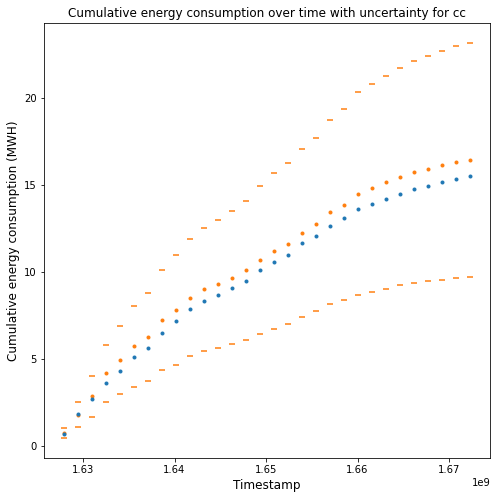

In [37]:
plot_cumulative_EC("cc", cc_expected, cc_user_labeled, cc_sensed_sd, cc_user_sd, cc_time_array)

In [22]:
pc_expected, pc_user_labeled, pc_sensed_sd, pc_user_sd, pc_time_array = get_cumulative_EC_lists(energy_consumption_df, "pc")

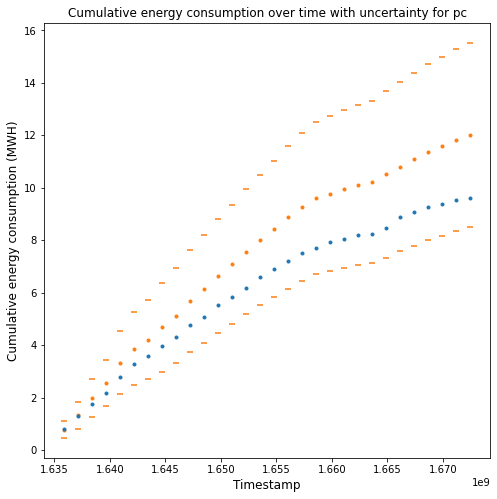

In [38]:
plot_cumulative_EC("pc", pc_expected, pc_user_labeled, pc_sensed_sd, pc_user_sd, pc_time_array)